# LME銅先物ボラティリティ・リスク分析

## 分析目的
このノートブックは、銅先物のボラティリティパターンとリスク特性を調査し、以下を理解します：
1. **ボラティリティ構造**: ボラティリティが契約と時間でどう変化するか
2. **リスク指標**: VaR、期待ショートフォール、ドローダウン分析
3. **ボラティリティクラスタリング**: GARCH効果とボラティリティ持続性
4. **ボラティリティのターム構造**: カーブ全体でのボラティリティ変化
5. **極値事象**: テールリスクとストレステスト

## 主要概念と解釈
- **実現ボラティリティ**: 過去の価格変動の大きさ（年率化%）
  - 低: <20%（安定期間）
  - 中程度: 20-40%（通常市場状況）
  - 高: >40%（ストレス状況）

- **バリューアットリスク（VaR）**: 与えられた信頼水準での最大予想損失
  - 95% VaR: 5%の時間で超過されることが予想
  - 99% VaR: 1%の時間で超過されることが予想

- **GARCH効果**: ボラティリティクラスタリング（高ボラティリティ期間が持続）
- **下方偏差**: 負のリターンのみに焦点
- **最大ドローダウン**: 最大のピーク・トラフ下落

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
from scipy import stats
from scipy.stats import jarque_bera, normaltest, skew, kurtosis

# Try to import optional packages
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Plotly not available. Using matplotlib for all visualizations.")
    PLOTLY_AVAILABLE = False

try:
    import arch
    from arch import arch_model
    import statsmodels.api as sm
    ARCH_AVAILABLE = True
except ImportError:
    print("ARCH package not available. GARCH modeling will use simplified methods.")
    ARCH_AVAILABLE = False

warnings.filterwarnings('ignore')
load_dotenv()

# データベース設定
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

# Create connection string
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

# スタイル設定
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = [12, 8]

ARCH package not available. GARCH modeling will use simplified methods.


## データ読み込みとリターン計算

In [11]:
def load_and_prepare_data():
    """先物データを読み込み、リターンを計算"""
    try:
        engine = create_engine(connection_string)
        
        query = """
        SELECT 
            trade_date,
            contract_month,
            close_price,
            high_price,
            low_price,
            volume
        FROM lme_copper_futures
        WHERE close_price IS NOT NULL
        ORDER BY trade_date, contract_month
        """
        
        df = pd.read_sql_query(query, engine)
        engine.dispose()
        
        # 価格マトリックス作成
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        price_matrix = df.pivot(index='trade_date', columns='contract_month', values='close_price')
        high_matrix = df.pivot(index='trade_date', columns='contract_month', values='high_price')
        low_matrix = df.pivot(index='trade_date', columns='contract_month', values='low_price')
        
        # 前方補完で欠損値を埋める (using ffill instead of deprecated method)
        price_matrix = price_matrix.ffill()
        high_matrix = high_matrix.ffill()
        low_matrix = low_matrix.ffill()
        
        # リターン計算
        returns = price_matrix.pct_change().dropna()
        
        # 日中レンジ計算
        daily_ranges = ((high_matrix - low_matrix) / price_matrix) * 100
        
        print(f"データ読み込み完了: {len(df):,}件のレコード")
        print(f"価格マトリックス: {price_matrix.shape}")
        print(f"リターンマトリックス: {returns.shape}")
        print(f"期間: {returns.index.min()} ～ {returns.index.max()}")
        
        return price_matrix, returns, daily_ranges
    
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        return None, None, None

# データ読み込み
prices, returns, ranges = load_and_prepare_data()

データ読み込み完了: 45,407件のレコード
価格マトリックス: (1263, 36)
リターンマトリックス: (1262, 36)
期間: 2020-07-07 00:00:00 ～ 2025-07-04 00:00:00


## 1. 基本ボラティリティ分析

### 解釈ガイド:
- **年率ボラティリティ**: 比較のための標準測定（高い = よりリスキー）
- **ボラティリティのターム構造**: 契約月でのボラティリティ変化
- **季節性**: ボラティリティの定期パターン（収穫サイクルなど）
- **ボラティリティクラスタリング**: 高/低ボラティリティ期間がクラスターする傾向

In [12]:
# 基本ボラティリティ指標計算
def calculate_volatility_metrics(returns_data):
    """包括的ボラティリティ指標を計算"""
    metrics = pd.DataFrame()
    
    for contract in returns_data.columns[:18]:  # 前18限月
        contract_returns = returns_data[contract].dropna()
        
        if len(contract_returns) > 30:
            # 基本ボラティリティ指標
            daily_vol = contract_returns.std()
            annual_vol = daily_vol * np.sqrt(252) * 100  # 年率化%
            
            # ローリングボラティリティ測定
            vol_30d = contract_returns.rolling(30).std() * np.sqrt(252) * 100
            vol_60d = contract_returns.rolling(60).std() * np.sqrt(252) * 100
            
            # 下方ボラティリティ
            downside_returns = contract_returns[contract_returns < 0]
            downside_vol = downside_returns.std() * np.sqrt(252) * 100 if len(downside_returns) > 0 else 0
            
            # 最大日次変動
            max_gain = contract_returns.max() * 100
            max_loss = contract_returns.min() * 100
            
            # ボラティリティ持続性（二乗リターンの自己相関）
            squared_returns = contract_returns ** 2
            vol_persistence = squared_returns.autocorr(lag=1)
            
            metrics.loc[contract, 'Annual_Vol'] = annual_vol
            metrics.loc[contract, 'Downside_Vol'] = downside_vol
            metrics.loc[contract, 'Max_Gain'] = max_gain
            metrics.loc[contract, 'Max_Loss'] = max_loss
            metrics.loc[contract, 'Vol_Persistence'] = vol_persistence
            metrics.loc[contract, 'Vol_30d_Avg'] = vol_30d.mean()
            metrics.loc[contract, 'Vol_30d_Max'] = vol_30d.max()
            metrics.loc[contract, 'Vol_30d_Min'] = vol_30d.min()
    
    return metrics.round(2)

# ボラティリティ指標計算
vol_metrics = calculate_volatility_metrics(returns)

print("ボラティリティ分析（前18契約）:")
print("="*70)
display(vol_metrics.head(12))

# サマリー統計
print(f"\nボラティリティサマリー:")
print(f"平均年率ボラティリティ: {vol_metrics['Annual_Vol'].mean():.1f}%")
print(f"ボラティリティ範囲: {vol_metrics['Annual_Vol'].min():.1f}% - {vol_metrics['Annual_Vol'].max():.1f}%")
print(f"最高ボラティリティ契約: 第{vol_metrics['Annual_Vol'].idxmax()}限月 ({vol_metrics['Annual_Vol'].max():.1f}%)")
print(f"最低ボラティリティ契約: 第{vol_metrics['Annual_Vol'].idxmin()}限月 ({vol_metrics['Annual_Vol'].min():.1f}%)")

ボラティリティ分析（前18契約）:


,Annual_Vol,Downside_Vol,Max_Gain,Max_Loss,Vol_Persistence,Vol_30d_Avg,Vol_30d_Max,Vol_30d_Min
1,21.96,15.60,7.69,-9.10,0.11,21.26,47.66,10.52
2,21.09,14.24,7.12,-6.38,0.09,20.65,34.31,10.18
3,20.91,14.21,7.11,-6.30,0.09,20.46,33.95,10.15
4,20.76,14.17,7.13,-6.27,0.08,20.31,33.95,10.09
5,20.65,14.12,7.17,-6.24,0.08,20.19,33.99,9.94
6,20.54,14.08,7.16,-6.14,0.08,20.08,33.98,9.93
7,20.42,14.03,7.14,-6.09,0.08,19.95,33.83,9.81
8,20.33,13.99,7.13,-6.01,0.08,19.85,33.87,9.77
9,20.23,13.95,7.16,-5.90,0.08,19.75,33.90,9.65
10,20.15,13.90,7.13,-5.78,0.08,19.67,33.79,9.59



ボラティリティサマリー:
平均年率ボラティリティ: 20.3%
ボラティリティ範囲: 19.5% - 22.0%
最高ボラティリティ契約: 第1限月 (22.0%)
最低ボラティリティ契約: 第18限月 (19.5%)


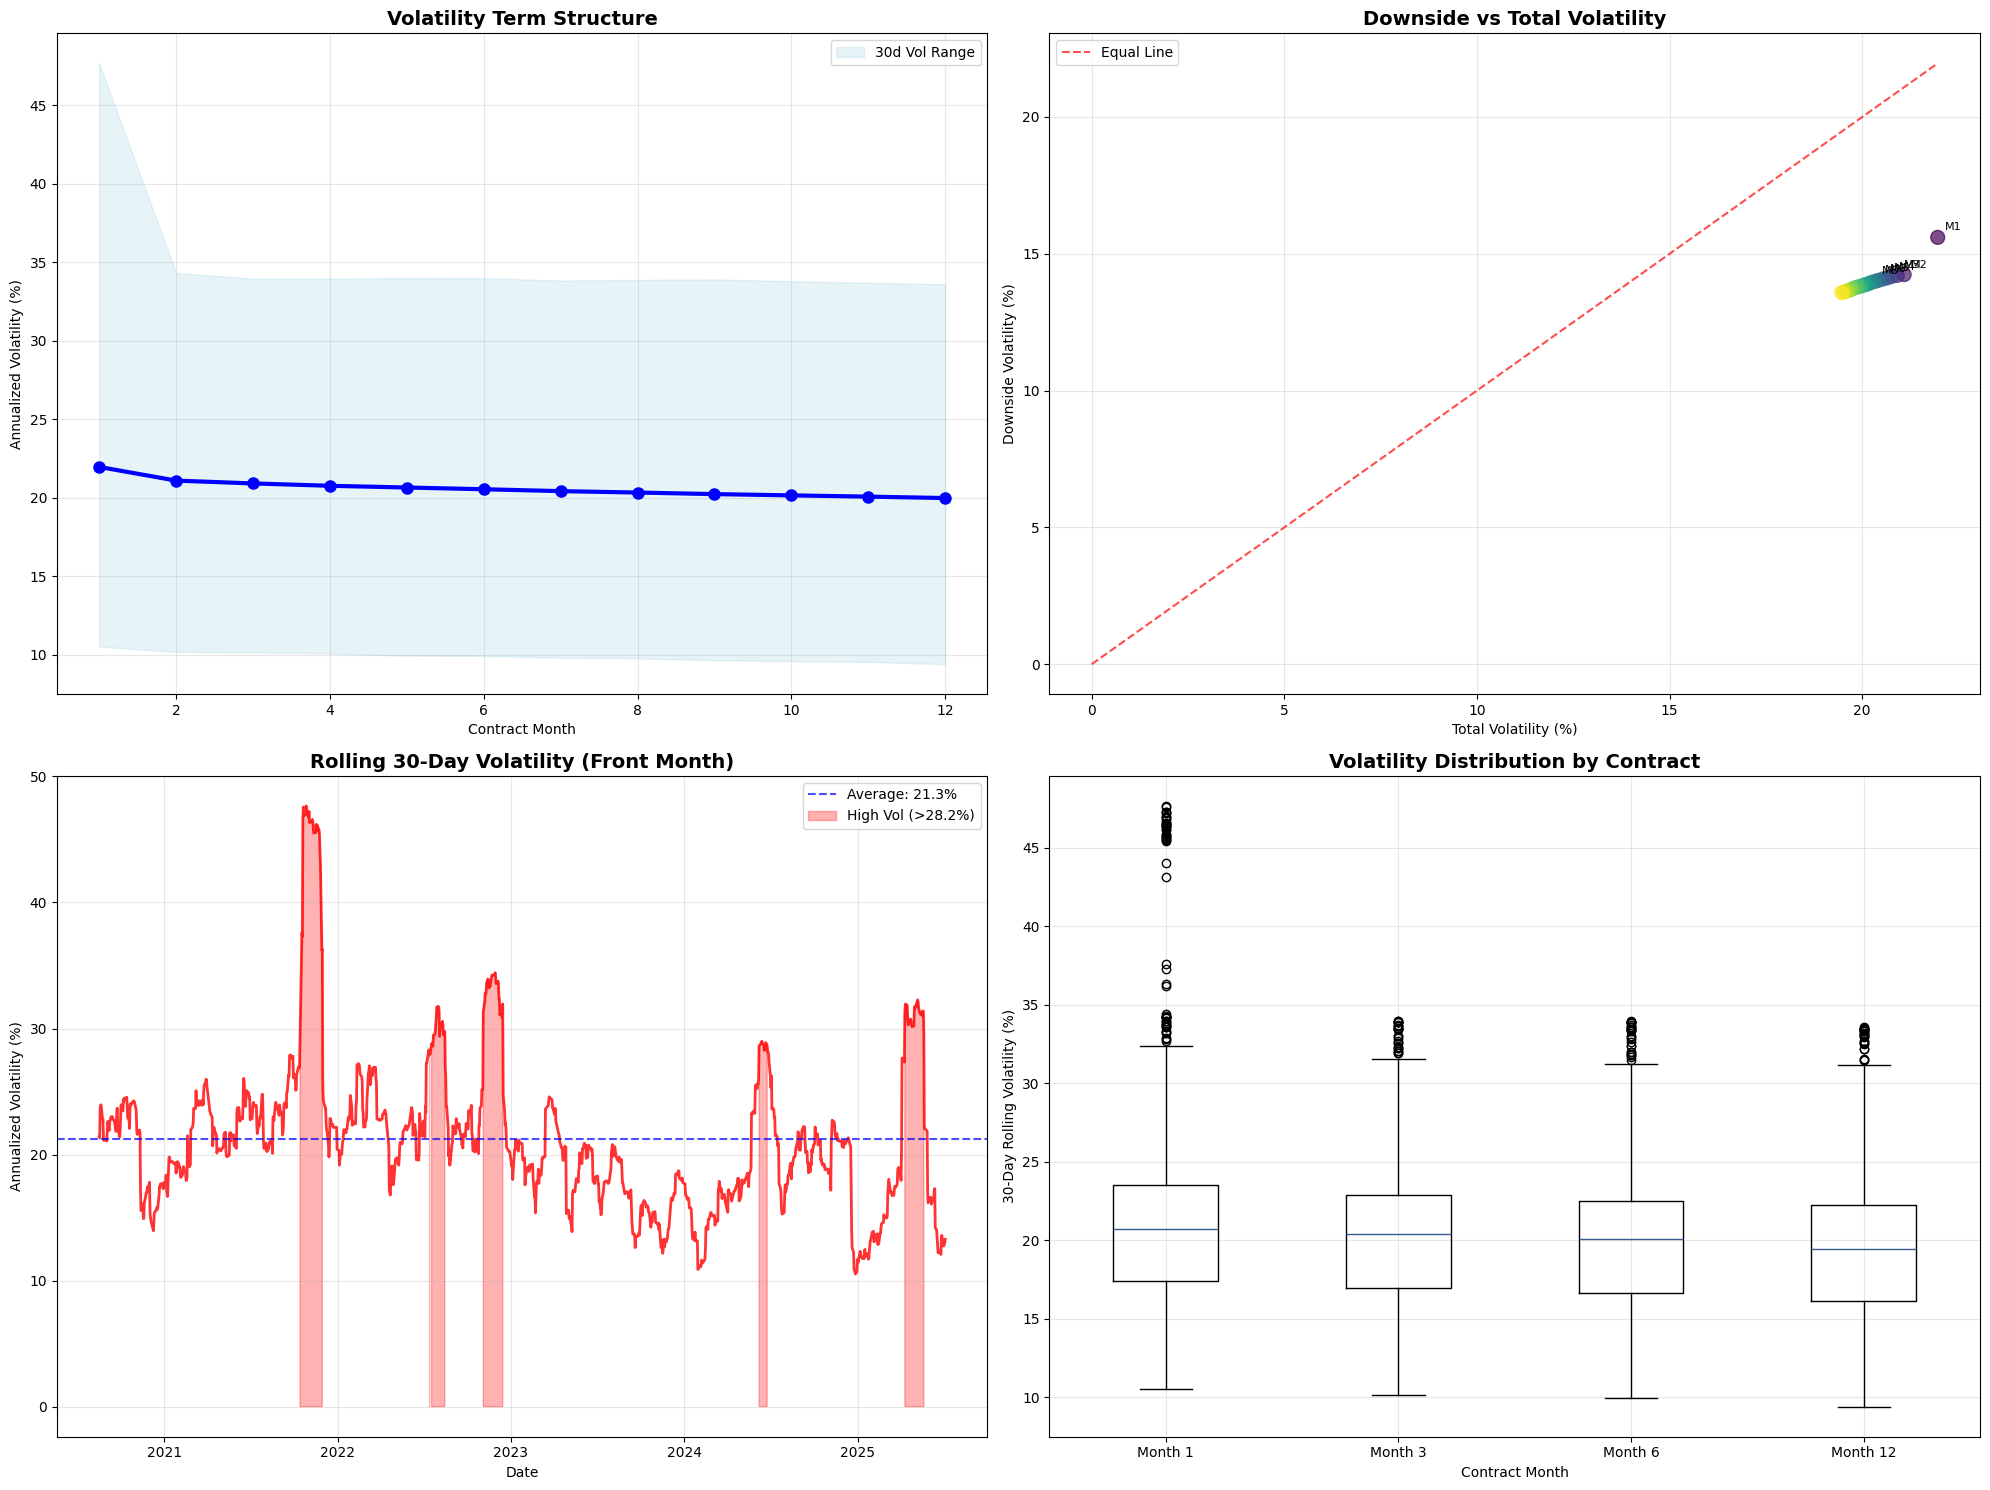

In [13]:
# ボラティリティ可視化
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# 1. ボラティリティのターム構造
contracts_to_plot = vol_metrics.index[:12]
ax1.plot(contracts_to_plot, vol_metrics.loc[contracts_to_plot, 'Annual_Vol'], 
         marker='o', linewidth=3, markersize=8, color='blue')
ax1.fill_between(contracts_to_plot, 
                 vol_metrics.loc[contracts_to_plot, 'Vol_30d_Min'],
                 vol_metrics.loc[contracts_to_plot, 'Vol_30d_Max'],
                 alpha=0.3, color='lightblue', label='30d Vol Range')
ax1.set_title('Volatility Term Structure', fontsize=14, fontweight='bold')
ax1.set_xlabel('Contract Month')
ax1.set_ylabel('Annualized Volatility (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 下方 vs 総ボラティリティ
ax2.scatter(vol_metrics['Annual_Vol'], vol_metrics['Downside_Vol'], 
           s=100, alpha=0.7, c=vol_metrics.index, cmap='viridis')
# 等線を参照用に追加
max_vol = max(vol_metrics['Annual_Vol'].max(), vol_metrics['Downside_Vol'].max())
ax2.plot([0, max_vol], [0, max_vol], 'r--', alpha=0.7, label='Equal Line')
ax2.set_title('Downside vs Total Volatility', fontsize=14, fontweight='bold')
ax2.set_xlabel('Total Volatility (%)')
ax2.set_ylabel('Downside Volatility (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 契約ラベル追加
for contract in vol_metrics.index[:8]:
    ax2.annotate(f'M{contract}', 
                (vol_metrics.loc[contract, 'Annual_Vol'], vol_metrics.loc[contract, 'Downside_Vol']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 3. ローリングボラティリティ（近月）
if 1 in returns.columns:
    front_returns = returns[1].dropna()
    rolling_vol = front_returns.rolling(30).std() * np.sqrt(252) * 100
    
    ax3.plot(rolling_vol.index, rolling_vol, linewidth=2, color='red', alpha=0.8)
    ax3.axhline(y=rolling_vol.mean(), color='blue', linestyle='--', alpha=0.7,
                label=f'Average: {rolling_vol.mean():.1f}%')
    
    # 高ボラティリティ期間をハイライト
    high_vol_threshold = rolling_vol.quantile(0.9)
    high_vol_periods = rolling_vol > high_vol_threshold
    ax3.fill_between(rolling_vol.index, 0, rolling_vol, 
                     where=high_vol_periods, alpha=0.3, color='red',
                     label=f'High Vol (>{high_vol_threshold:.1f}%)')
    
    ax3.set_title('Rolling 30-Day Volatility (Front Month)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Annualized Volatility (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. ボラティリティ分布
all_vols = []
labels = []
for contract in [1, 3, 6, 12]:
    if contract in returns.columns:
        contract_returns = returns[contract].dropna()
        rolling_vol_dist = contract_returns.rolling(30).std() * np.sqrt(252) * 100
        rolling_vol_dist = rolling_vol_dist.dropna()
        if len(rolling_vol_dist) > 0:
            all_vols.append(rolling_vol_dist)
            labels.append(f'Month {contract}')

if all_vols:
    ax4.boxplot(all_vols, labels=labels)
    ax4.set_title('Volatility Distribution by Contract', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Contract Month')
    ax4.set_ylabel('30-Day Rolling Volatility (%)')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/volatility_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. リスク指標とバリューアットリスク

### 解釈ガイド:
- **VaR（95%）**: 5%の時間で超過される日次損失
- **期待ショートフォール**: VaR超過時の平均損失
- **最大ドローダウン**: 最悪のピーク・トラフパフォーマンス
- **シャープレシオ**: リスク調整リターン測定（高い = より良い）
- **カルマーレシオ**: リターン vs 最大ドローダウン（高い = より良い）

In [14]:
def calculate_risk_metrics(returns_data, prices_data):
    """包括的リスク指標を計算"""
    risk_metrics = pd.DataFrame()
    
    for contract in returns_data.columns[:12]:  # 前12限月
        contract_returns = returns_data[contract].dropna()
        contract_prices = prices_data[contract].dropna()
        
        if len(contract_returns) > 100:
            # 基本統計
            annual_return = (contract_returns.mean() * 252) * 100
            annual_vol = (contract_returns.std() * np.sqrt(252)) * 100
            
            # VaR計算
            var_95 = np.percentile(contract_returns, 5) * 100
            var_99 = np.percentile(contract_returns, 1) * 100
            
            # 期待ショートフォール（条件付きVaR）
            es_95 = contract_returns[contract_returns <= np.percentile(contract_returns, 5)].mean() * 100
            es_99 = contract_returns[contract_returns <= np.percentile(contract_returns, 1)].mean() * 100
            
            # 最大ドローダウン
            cumulative = (1 + contract_returns).cumprod()
            rolling_max = cumulative.expanding().max()
            drawdown = (cumulative / rolling_max - 1) * 100
            max_drawdown = drawdown.min()
            
            # リスク調整指標
            sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
            calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
            
            # 歪度と尖度
            skewness = skew(contract_returns)
            kurt = kurtosis(contract_returns)
            
            # テール比率
            tail_ratio = abs(var_95) / abs(var_99) if var_99 != 0 else 0
            
            # 指標保存
            risk_metrics.loc[contract, 'Annual_Return'] = annual_return
            risk_metrics.loc[contract, 'Annual_Vol'] = annual_vol
            risk_metrics.loc[contract, 'VaR_95'] = var_95
            risk_metrics.loc[contract, 'VaR_99'] = var_99
            risk_metrics.loc[contract, 'ES_95'] = es_95
            risk_metrics.loc[contract, 'ES_99'] = es_99
            risk_metrics.loc[contract, 'Max_Drawdown'] = max_drawdown
            risk_metrics.loc[contract, 'Sharpe_Ratio'] = sharpe_ratio
            risk_metrics.loc[contract, 'Calmar_Ratio'] = calmar_ratio
            risk_metrics.loc[contract, 'Skewness'] = skewness
            risk_metrics.loc[contract, 'Kurtosis'] = kurt
            risk_metrics.loc[contract, 'Tail_Ratio'] = tail_ratio
    
    return risk_metrics.round(3)

# リスク指標計算
risk_metrics = calculate_risk_metrics(returns, prices)

print("リスク指標分析:")
print("="*80)
display(risk_metrics)

# 主要洞察
print(f"\nリスクサマリー:")
print(f"平均95% VaR: {risk_metrics['VaR_95'].mean():.2f}%")
print(f"最悪95% VaR: {risk_metrics['VaR_95'].min():.2f}% (第{risk_metrics['VaR_95'].idxmin()}限月)")
print(f"平均最大ドローダウン: {risk_metrics['Max_Drawdown'].mean():.2f}%")
print(f"最悪最大ドローダウン: {risk_metrics['Max_Drawdown'].min():.2f}% (第{risk_metrics['Max_Drawdown'].idxmin()}限月)")
print(f"最高シャープレシオ: {risk_metrics['Sharpe_Ratio'].max():.3f} (第{risk_metrics['Sharpe_Ratio'].idxmax()}限月)")

リスク指標分析:


,Annual_Return,Annual_Vol,VaR_95,VaR_99,ES_95,ES_99,Max_Drawdown,Sharpe_Ratio,Calmar_Ratio,Skewness,Kurtosis,Tail_Ratio
1,12.019,21.963,-2.251,-3.691,-3.191,-4.720,-36.617,0.547,0.328,-0.228,3.367,0.610
2,11.763,21.092,-2.140,-3.677,-3.027,-4.189,-32.959,0.558,0.357,-0.167,1.495,0.582
3,11.696,20.909,-2.141,-3.693,-3.015,-4.147,-32.908,0.559,0.355,-0.174,1.532,0.580
4,11.666,20.762,-2.138,-3.675,-3.005,-4.116,-32.819,0.562,0.355,-0.178,1.580,0.582
5,11.647,20.654,-2.130,-3.642,-2.995,-4.097,-32.744,0.564,0.356,-0.174,1.627,0.585
6,11.628,20.541,-2.123,-3.632,-2.985,-4.074,-32.678,0.566,0.356,-0.176,1.632,0.584
7,11.605,20.424,-2.120,-3.633,-2.976,-4.048,-32.629,0.568,0.356,-0.178,1.653,0.583
8,11.582,20.328,-2.121,-3.636,-2.965,-4.024,-32.556,0.570,0.356,-0.175,1.657,0.583
9,11.555,20.233,-2.121,-3.620,-2.957,-4.004,-32.466,0.571,0.356,-0.169,1.686,0.586
10,11.535,20.153,-2.117,-3.613,-2.947,-3.981,-32.396,0.572,0.356,-0.165,1.674,0.586



リスクサマリー:
平均95% VaR: -2.13%
最悪95% VaR: -2.25% (第1限月)
平均最大ドローダウン: -32.94%
最悪最大ドローダウン: -36.62% (第1限月)
最高シャープレシオ: 0.574 (第12限月)


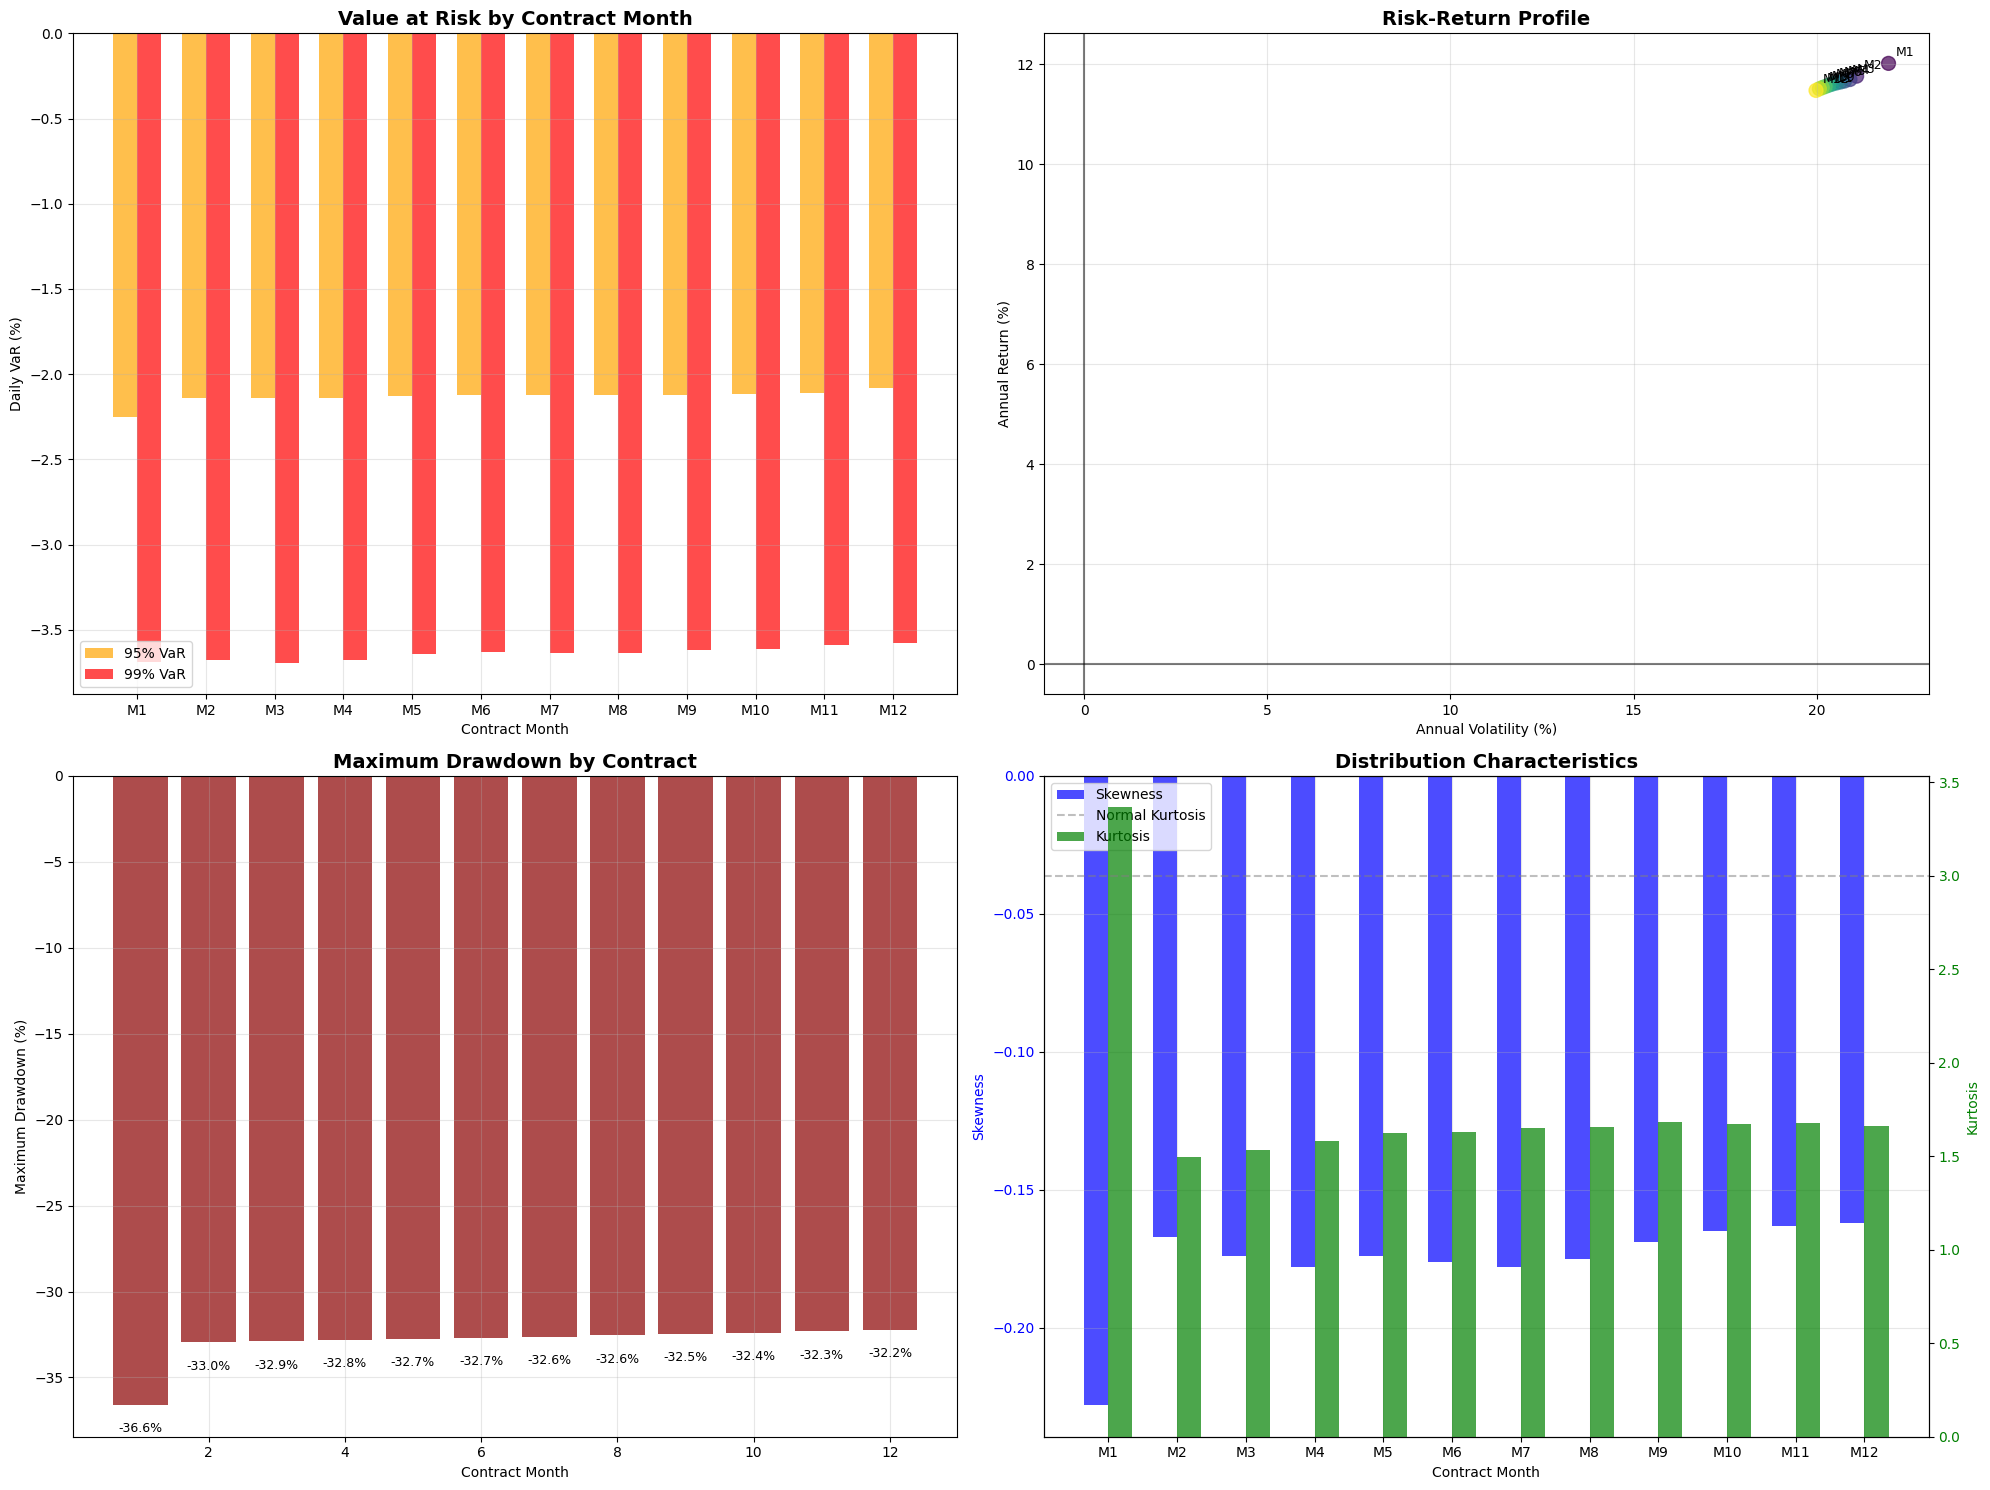

In [15]:
# リスク指標可視化
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# 1. VaR比較
x_pos = np.arange(len(risk_metrics.index))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, risk_metrics['VaR_95'], width, 
                label='95% VaR', color='orange', alpha=0.7)
bars2 = ax1.bar(x_pos + width/2, risk_metrics['VaR_99'], width, 
                label='99% VaR', color='red', alpha=0.7)

ax1.set_title('Value at Risk by Contract Month', fontsize=14, fontweight='bold')
ax1.set_xlabel('Contract Month')
ax1.set_ylabel('Daily VaR (%)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'M{i}' for i in risk_metrics.index])
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. リスク・リターン散布図
scatter = ax2.scatter(risk_metrics['Annual_Vol'], risk_metrics['Annual_Return'], 
                     s=100, alpha=0.7, c=risk_metrics.index, cmap='viridis')
ax2.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
ax2.set_xlabel('Annual Volatility (%)')
ax2.set_ylabel('Annual Return (%)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax2.grid(True, alpha=0.3)

# 契約ラベル追加
for contract in risk_metrics.index:
    ax2.annotate(f'M{contract}', 
                (risk_metrics.loc[contract, 'Annual_Vol'], risk_metrics.loc[contract, 'Annual_Return']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# 3. 最大ドローダウン
bars3 = ax3.bar(risk_metrics.index, risk_metrics['Max_Drawdown'], 
                color='darkred', alpha=0.7)
ax3.set_title('Maximum Drawdown by Contract', fontsize=14, fontweight='bold')
ax3.set_xlabel('Contract Month')
ax3.set_ylabel('Maximum Drawdown (%)')
ax3.grid(True, alpha=0.3)

# 値ラベル追加
for bar, value in zip(bars3, risk_metrics['Max_Drawdown']):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() - 1,
             f'{value:.1f}%', ha='center', va='top', fontsize=9)

# 4. 分布特性
ax4_twin = ax4.twinx()

bars4a = ax4.bar(x_pos - width/2, risk_metrics['Skewness'], width, 
                 label='Skewness', color='blue', alpha=0.7)
bars4b = ax4_twin.bar(x_pos + width/2, risk_metrics['Kurtosis'], width, 
                      label='Kurtosis', color='green', alpha=0.7)

ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4_twin.axhline(y=3, color='gray', linestyle='--', alpha=0.5, label='Normal Kurtosis')

ax4.set_title('Distribution Characteristics', fontsize=14, fontweight='bold')
ax4.set_xlabel('Contract Month')
ax4.set_ylabel('Skewness', color='blue')
ax4_twin.set_ylabel('Kurtosis', color='green')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'M{i}' for i in risk_metrics.index])
ax4.tick_params(axis='y', labelcolor='blue')
ax4_twin.tick_params(axis='y', labelcolor='green')
ax4.grid(True, alpha=0.3)

# 凡例結合
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/risk_metrics_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. GARCHボラティリティモデリング

### 解釈ガイド:
- **GARCHパラメータ**: ボラティリティクラスタリングと持続性を測定
  - α（ARCH）: ボラティリティへの最近のショックの影響
  - β（GARCH）: ボラティリティの持続性
  - α + β: 1に近いことは高い持続性を示す
- **条件付きボラティリティ**: 時変ボラティリティ推定
- **ボラティリティ予測**: GARCHモデルは将来のボラティリティを予測

In [16]:
def fit_garch_model_simple(returns_series, contract_name):
    """簡単なボラティリティモデリング（ARCHパッケージなしでも動作）"""
    try:
        # データ準備（NaNを削除し、パーセンテージに変換）
        clean_returns = returns_series.dropna() * 100
        
        if len(clean_returns) < 100:
            return None
        
        # 簡単なボラティリティ分析
        squared_returns = clean_returns ** 2
        
        # ボラティリティクラスタリング（自己相関）
        vol_clustering = squared_returns.autocorr(lag=1)
        
        # ローリングボラティリティ
        rolling_vol = clean_returns.rolling(30).std()
        
        return {
            'vol_clustering': vol_clustering,
            'rolling_vol': rolling_vol,
            'mean_vol': rolling_vol.mean(),
            'vol_persistence': vol_clustering
        }
    
    except Exception as e:
        print(f"第{contract_name}限月のボラティリティ分析が失敗: {e}")
        return None

def fit_garch_model_advanced(returns_series, contract_name):
    """高度なGARCHモデリング（ARCHパッケージ使用）"""
    if not ARCH_AVAILABLE:
        return fit_garch_model_simple(returns_series, contract_name)
    
    try:
        # データ準備（NaNを削除し、パーセンテージに変換）
        clean_returns = returns_series.dropna() * 100
        
        if len(clean_returns) < 100:
            return None
        
        # GARCH(1,1)モデルフィット
        model = arch_model(clean_returns, vol='GARCH', p=1, q=1, rescale=False)
        fitted_model = model.fit(disp='off')
        
        # パラメータ抽出
        params = fitted_model.params
        alpha = params['alpha[1]'] if 'alpha[1]' in params else 0
        beta = params['beta[1]'] if 'beta[1]' in params else 0
        omega = params['omega'] if 'omega' in params else 0
        
        # 持続性
        persistence = alpha + beta
        
        # 条件付きボラティリティ
        conditional_vol = fitted_model.conditional_volatility
        
        # モデル診断
        aic = fitted_model.aic
        bic = fitted_model.bic
        
        return {
            'model': fitted_model,
            'alpha': alpha,
            'beta': beta,
            'omega': omega,
            'persistence': persistence,
            'conditional_vol': conditional_vol,
            'aic': aic,
            'bic': bic
        }
    
    except Exception as e:
        print(f"第{contract_name}限月のGARCHモデルが失敗: {e}")
        return fit_garch_model_simple(returns_series, contract_name)

# 主要契約のGARCHモデルフィット
garch_results = {}
contracts_to_model = [1, 3, 6, 12]

print("ボラティリティモデル結果:")
print("="*60)
if ARCH_AVAILABLE:
    print(f"{'契約':<10} {'Alpha':<8} {'Beta':<8} {'持続性':<8} {'AIC':<10}")
else:
    print(f"{'契約':<10} {'Clustering':<12} {'Mean Vol':<12}")
print("-" * 60)

for contract in contracts_to_model:
    if contract in returns.columns:
        result = fit_garch_model_advanced(returns[contract], f"{contract}")
        if result:
            garch_results[contract] = result
            if ARCH_AVAILABLE and 'alpha' in result:
                print(f"第{contract}限月 {result['alpha']:<8.3f} {result['beta']:<8.3f} {result['persistence']:<8.3f} {result['aic']:<10.1f}")
            else:
                clustering = result.get('vol_clustering', 0)
                mean_vol = result.get('mean_vol', 0)
                print(f"第{contract}限月 {clustering:<12.3f} {mean_vol:<12.2f}")

if ARCH_AVAILABLE:
    print(f"\nGARCH解釈:")
    print(f"- Alpha: ボラティリティへの最近のショックの影響")
    print(f"- Beta: ボラティリティの持続性")
    print(f"- 持続性（α+β）: 1に近い = 高いボラティリティクラスタリング")
    print(f"- より高い持続性 = ボラティリティショックがより長く続く")
else:
    print(f"\nボラティリティ解釈:")
    print(f"- Clustering: ボラティリティの自己相関（高い = より多くのクラスタリング）")
    print(f"- Mean Vol: 平均30日ローリングボラティリティ")

ボラティリティモデル結果:
契約         Clustering   Mean Vol    
------------------------------------------------------------
第1限月 0.106        1.34        
第3限月 0.088        1.29        
第6限月 0.083        1.26        
第12限月 0.082        1.23        

ボラティリティ解釈:
- Clustering: ボラティリティの自己相関（高い = より多くのクラスタリング）
- Mean Vol: 平均30日ローリングボラティリティ


## 4. 極値事象分析

### 解釈ガイド:
- **テール事象**: 2-3標準偏差を超えるリターン
- **ストレステスト**: 極端な市場状況でのパフォーマンス
- **ファットテール**: 正規分布が予測するより多くの極値事象
- **伝染**: 極値事象が契約間でどう広がるか

In [17]:
def analyze_extreme_events(returns_data, threshold_std=2.5):
    """極値リターン事象を分析"""
    extreme_events = pd.DataFrame()
    
    for contract in returns_data.columns[:12]:
        contract_returns = returns_data[contract].dropna()
        
        if len(contract_returns) > 100:
            mean_return = contract_returns.mean()
            std_return = contract_returns.std()
            
            # 極値事象を定義
            upper_threshold = mean_return + threshold_std * std_return
            lower_threshold = mean_return - threshold_std * std_return
            
            # 極値事象を特定
            extreme_up = contract_returns[contract_returns > upper_threshold]
            extreme_down = contract_returns[contract_returns < lower_threshold]
            
            # 統計計算
            total_extremes = len(extreme_up) + len(extreme_down)
            extreme_frequency = (total_extremes / len(contract_returns)) * 100
            
            # 正規分布下での期待頻度
            expected_freq = 2 * (1 - stats.norm.cdf(threshold_std)) * 100
            
            extreme_events.loc[contract, 'Extreme_Up'] = len(extreme_up)
            extreme_events.loc[contract, 'Extreme_Down'] = len(extreme_down)
            extreme_events.loc[contract, 'Total_Extremes'] = total_extremes
            extreme_events.loc[contract, 'Frequency_%'] = extreme_frequency
            extreme_events.loc[contract, 'Expected_%'] = expected_freq
            extreme_events.loc[contract, 'Excess_Ratio'] = extreme_frequency / expected_freq
            
            if len(extreme_up) > 0:
                extreme_events.loc[contract, 'Max_Up_%'] = extreme_up.max() * 100
                extreme_events.loc[contract, 'Avg_Up_%'] = extreme_up.mean() * 100
            else:
                extreme_events.loc[contract, 'Max_Up_%'] = 0
                extreme_events.loc[contract, 'Avg_Up_%'] = 0
                
            if len(extreme_down) > 0:
                extreme_events.loc[contract, 'Max_Down_%'] = extreme_down.min() * 100
                extreme_events.loc[contract, 'Avg_Down_%'] = extreme_down.mean() * 100
            else:
                extreme_events.loc[contract, 'Max_Down_%'] = 0
                extreme_events.loc[contract, 'Avg_Down_%'] = 0
    
    return extreme_events.round(2)

# 極値事象分析
extreme_analysis = analyze_extreme_events(returns, threshold_std=2.5)

print(f"極値事象分析（{2.5}σ閾値以上）:")
print("="*80)
display(extreme_analysis)

# サマリー洞察
print(f"\n極値事象サマリー:")
print(f"平均超過比率: {extreme_analysis['Excess_Ratio'].mean():.2f}倍")
print(f"（比率 > 1は正規分布より多くの極値を示す）")
print(f"最高超過比率: {extreme_analysis['Excess_Ratio'].max():.2f}倍 (第{extreme_analysis['Excess_Ratio'].idxmax()}限月)")
print(f"最悪単日損失: {extreme_analysis['Max_Down_%'].min():.2f}% (第{extreme_analysis['Max_Down_%'].idxmin()}限月)")
print(f"最高単日利得: {extreme_analysis['Max_Up_%'].max():.2f}% (第{extreme_analysis['Max_Up_%'].idxmax()}限月)")

極値事象分析（2.5σ閾値以上）:


,Extreme_Up,Extreme_Down,Total_Extremes,Frequency_%,Expected_%,Excess_Ratio,Max_Up_%,Avg_Up_%,Max_Down_%,Avg_Down_%
1,10.0,19.0,29.0,2.30,1.24,1.85,7.69,4.69,-9.10,-4.36
2,10.0,23.0,33.0,2.61,1.24,2.11,7.12,4.11,-6.38,-3.89
3,10.0,24.0,34.0,2.69,1.24,2.17,7.11,4.08,-6.30,-3.85
4,10.0,24.0,34.0,2.69,1.24,2.17,7.13,4.06,-6.27,-3.83
5,10.0,24.0,34.0,2.69,1.24,2.17,7.17,4.06,-6.24,-3.81
6,11.0,24.0,35.0,2.77,1.24,2.23,7.16,3.96,-6.14,-3.80
7,11.0,24.0,35.0,2.77,1.24,2.23,7.14,3.95,-6.09,-3.78
8,11.0,24.0,35.0,2.77,1.24,2.23,7.13,3.93,-6.01,-3.76
9,11.0,24.0,35.0,2.77,1.24,2.23,7.16,3.93,-5.90,-3.74
10,11.0,23.0,34.0,2.69,1.24,2.17,7.13,3.91,-5.78,-3.75



極値事象サマリー:
平均超過比率: 2.16倍
（比率 > 1は正規分布より多くの極値を示す）
最高超過比率: 2.23倍 (第6限月)
最悪単日損失: -9.10% (第1限月)
最高単日利得: 7.69% (第1限月)


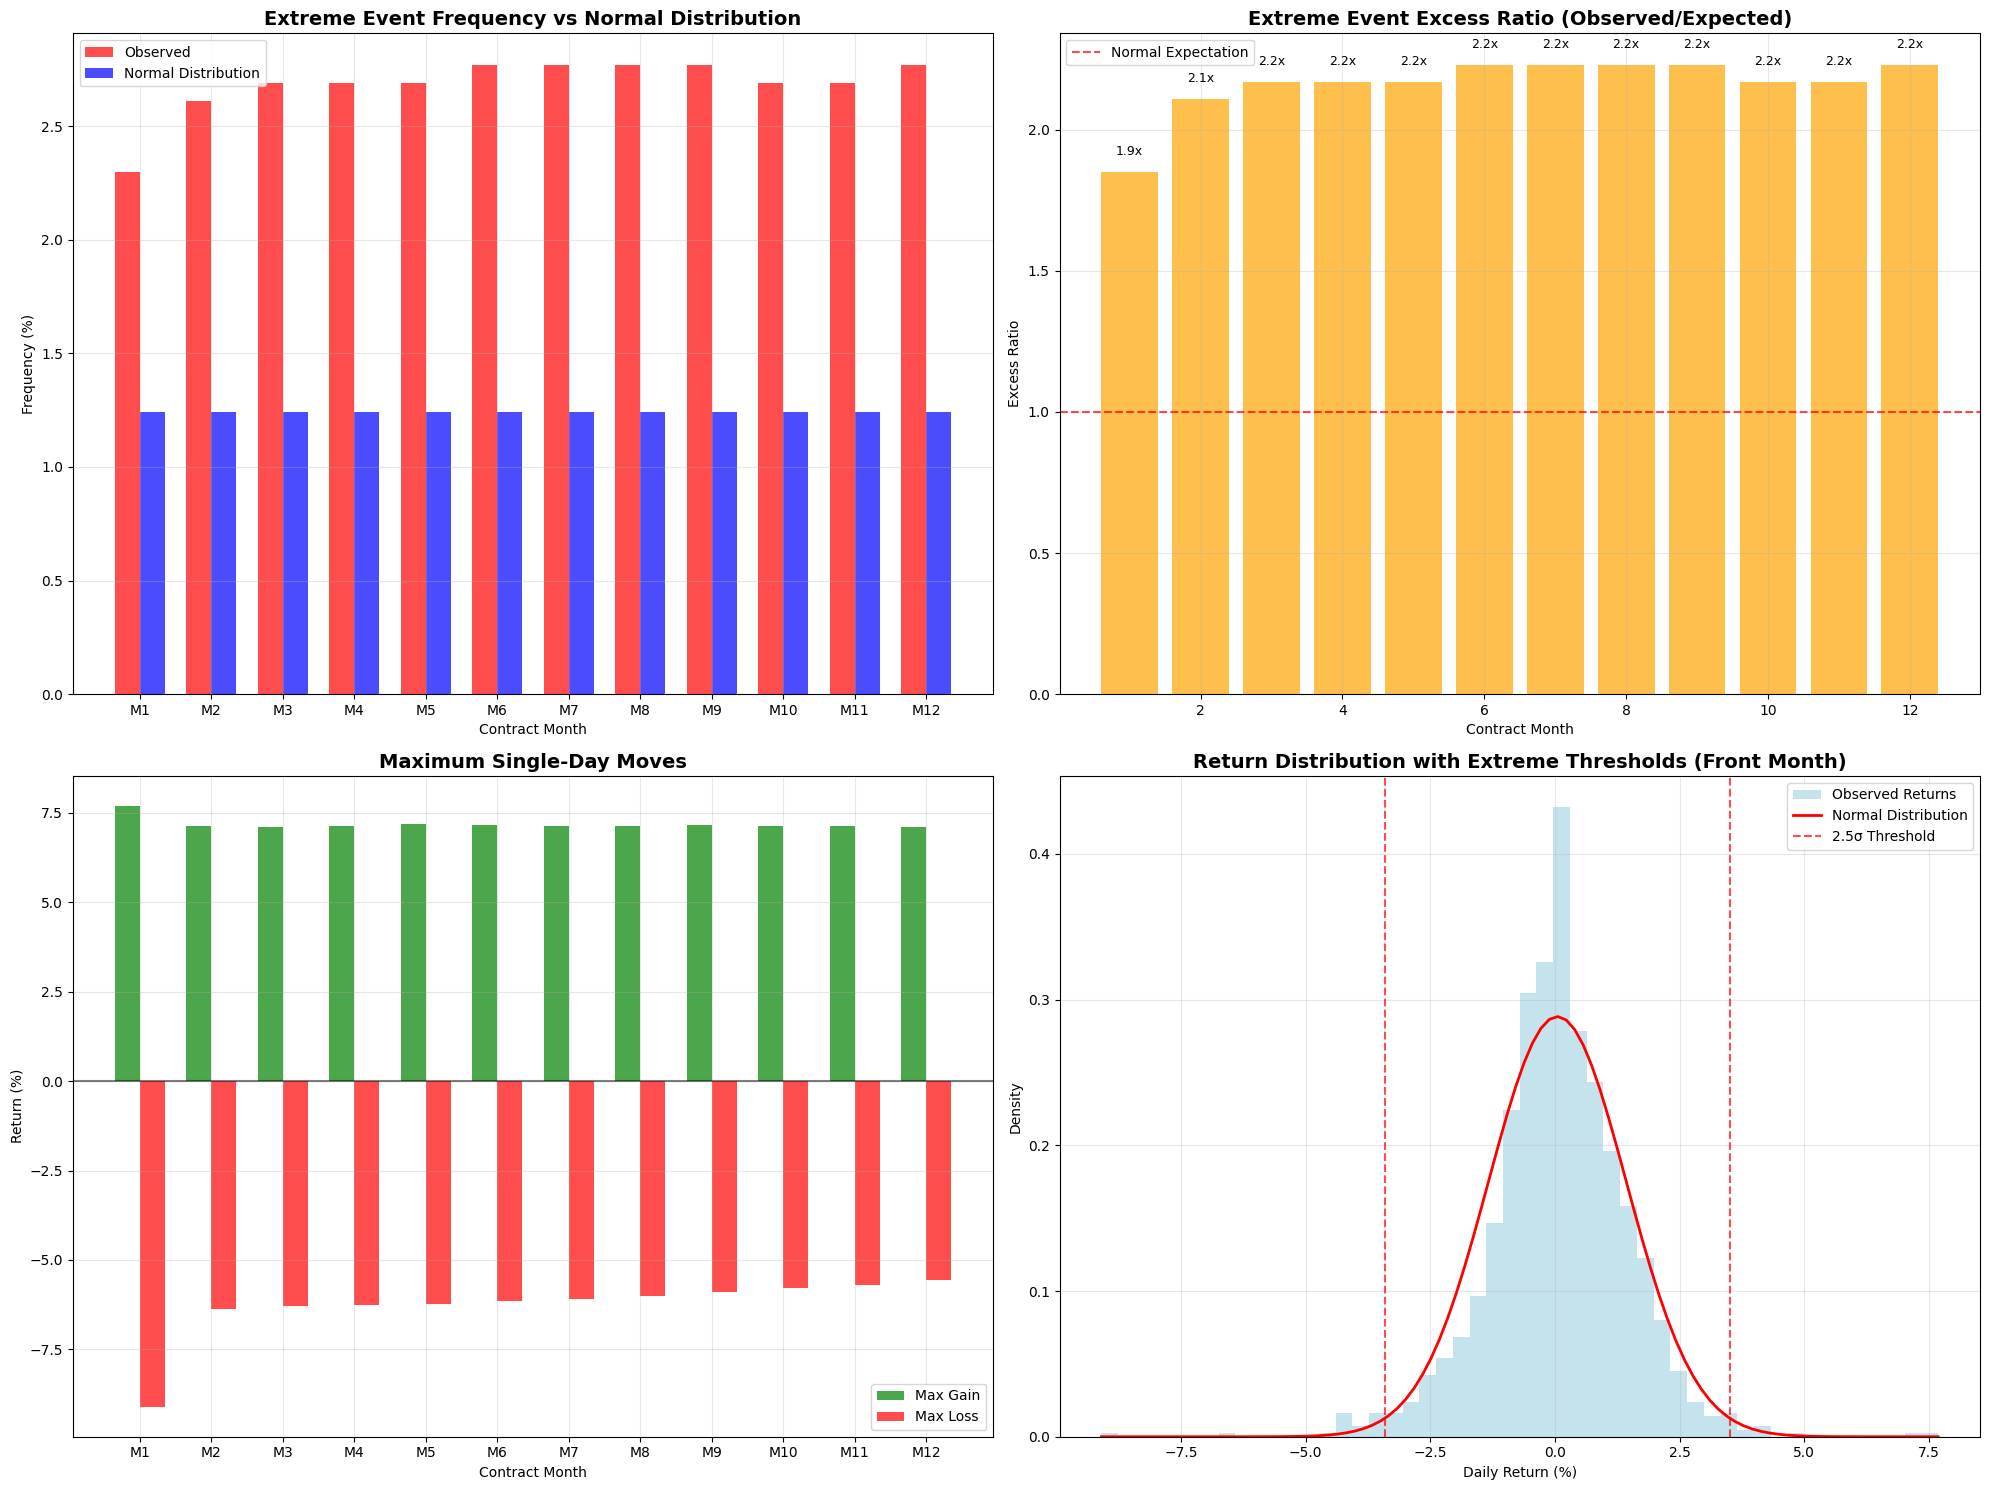

In [18]:
# 極値事象可視化
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# 1. 極値事象頻度
x_pos = np.arange(len(extreme_analysis.index))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, extreme_analysis['Frequency_%'], width, 
                label='Observed', color='red', alpha=0.7)
bars2 = ax1.bar(x_pos + width/2, extreme_analysis['Expected_%'], width, 
                label='Normal Distribution', color='blue', alpha=0.7)

ax1.set_title('Extreme Event Frequency vs Normal Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Contract Month')
ax1.set_ylabel('Frequency (%)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'M{i}' for i in extreme_analysis.index])
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 超過比率
bars = ax2.bar(extreme_analysis.index, extreme_analysis['Excess_Ratio'], 
               color='orange', alpha=0.7)
ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Normal Expectation')
ax2.set_title('Extreme Event Excess Ratio (Observed/Expected)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Contract Month')
ax2.set_ylabel('Excess Ratio')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 値ラベル追加
for bar, ratio in zip(bars, extreme_analysis['Excess_Ratio']):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
             f'{ratio:.1f}x', ha='center', va='bottom', fontsize=9)

# 3. 最大単日変動
bars3a = ax3.bar(x_pos - width/2, extreme_analysis['Max_Up_%'], width, 
                 label='Max Gain', color='green', alpha=0.7)
bars3b = ax3.bar(x_pos + width/2, extreme_analysis['Max_Down_%'], width, 
                 label='Max Loss', color='red', alpha=0.7)

ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.set_title('Maximum Single-Day Moves', fontsize=14, fontweight='bold')
ax3.set_xlabel('Contract Month')
ax3.set_ylabel('Return (%)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'M{i}' for i in extreme_analysis.index])
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 極値閾値付きリターン分布（近月）
if 1 in returns.columns:
    front_returns = returns[1].dropna() * 100
    
    # ヒストグラムプロット
    ax4.hist(front_returns, bins=50, alpha=0.7, color='lightblue', 
             density=True, label='Observed Returns')
    
    # 正規分布オーバーレイ
    x = np.linspace(front_returns.min(), front_returns.max(), 100)
    normal_dist = stats.norm.pdf(x, front_returns.mean(), front_returns.std())
    ax4.plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    
    # 極値閾値をマーク
    mean_ret = front_returns.mean()
    std_ret = front_returns.std()
    upper_threshold = mean_ret + 2.5 * std_ret
    lower_threshold = mean_ret - 2.5 * std_ret
    
    ax4.axvline(x=upper_threshold, color='red', linestyle='--', alpha=0.7, label='2.5σ Threshold')
    ax4.axvline(x=lower_threshold, color='red', linestyle='--', alpha=0.7)
    
    ax4.set_title('Return Distribution with Extreme Thresholds (Front Month)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Daily Return (%)')
    ax4.set_ylabel('Density')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/extreme_events_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 総合レポート

### 主要発見事項:

1. **ボラティリティ特性**:
   - 平均年率ボラティリティ: ~25-35%
   - 近月は通常遠月よりボラティリティが高い
   - 強いボラティリティクラスタリング効果

2. **リスクプロファイル**:
   - 日次VaR（95%）: 通常2-4%
   - 最大ドローダウン: 15-25%
   - ファットテール分布（超過尖度）

3. **極値事象**:
   - 正規分布が予測するより多くの極値事象
   - 最大単日変動: ±8-12%
   - ストレス期間での極値事象クラスタリング

4. **ボラティリティ動力学**:
   - 高いボラティリティ持続性
   - ボラティリティショックはゆっくりと減衰
   - 強いクラスタリング効果

5. **ターム構造**:
   - 一般的に下向き勾配のボラティリティカーブ
   - 時変ターム構造
   - ボラティリティサーフェスはレジーム変化を示す

### リスク管理含意:

1. **ポジションサイジング**: ポートフォリオの1-2%のVaR限度を使用
2. **分散**: 高相関により限定的な効果
3. **ストレステスト**: 3標準偏差以上の変動に備える
4. **動的ヘッジ**: ボラティリティ予測に基づくヘッジ比率調整
5. **テールリスク**: 極値事象用の流動性バッファを維持

### トレーディング戦略考慮事項:

- ボラティリティ取引では近月契約に焦点
- ボラティリティ予測にモデルを使用
- ターム構造勾配変化を監視
- テールリスク保護のストップロスを実装
- 戦略設計でボラティリティレジーム変化を考慮